In [1]:
import pandas as pd
from nilm_dao import *
import numpy as np
import torch
from torch.utils.data import DataLoader,TensorDataset
from ann_models import *

In [2]:
val_df = get_vndale1_data("val", 1800, True).to_pandas()
vndale_lb = get_label_encoder("vndale1")

Getting val data - window size: 1800: 100%|██████████| 128/128 [00:18<00:00,  6.97it/s]


In [3]:
val_df.head()

,Time,In,Un,PF_n,Irms,Urms,MeanPF,P,Q,S,Label
0,2024-01-16_18-45-40,0.153965,1.372587,-1.278665,-1.042554,0.452220,-1.398079,-1.053600,1.460315,-1.043066,30
1,2024-01-16_18-45-40,0.105476,1.348894,-1.278665,-1.042667,0.441311,-1.398105,-1.053736,1.457724,-1.043232,30
2,2024-01-16_18-45-40,0.019952,0.937338,-1.278665,-1.042718,0.425481,-1.398132,-1.053838,1.455801,-1.043355,30
3,2024-01-16_18-45-40,-0.020128,0.191542,-1.336678,-1.042715,0.420473,-1.398158,-1.053854,1.455523,-1.043375,30
4,2024-01-16_18-45-40,-0.030524,-0.466791,-1.336678,-1.042707,0.432442,-1.398149,-1.053803,1.456497,-1.043312,30


In [5]:
state_dict_path = "/home/mrcong/Code/mylab-nilm-files/nilm-physical-features/results/models/VNDALE1/window_1800/5_comb/mlp_['Irms', 'P', 'MeanPF', 'S', 'Q'].pt"
device = torch.device("cuda:0")
features = ["Irms", "P", "MeanPF", "S", "Q"]
print(f"[+] Evaluation on {device} with model path: {state_dict_path}")
ann_rms = AnnRMSModel(input_dim=len(features), output_dim=128, is_bn=False, dropout=0)
ann_rms.to(device)
if(os.path.isfile(state_dict_path)):
    ann_rms.load_state_dict(torch.load(state_dict_path))

[+] Evaluation on cuda:0 with model path: /home/mrcong/Code/mylab-nilm-files/nilm-physical-features/results/models/VNDALE1/window_1800/5_comb/mlp_['Irms', 'P', 'MeanPF', 'S', 'Q'].pt


/tmp/ipykernel_2814/1008623426.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ann_rms.load_state_dict(torch.load(state_dict_path))


In [6]:
X_val = torch.FloatTensor(val_df[features].to_numpy())
y_val = torch.LongTensor(val_df["Label"].to_numpy())
val_dataDataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataDataset, batch_size=512, drop_last=False, num_workers=12, pin_memory=True, persistent_workers=True)

In [7]:
def evaluate_test_dataset(device, model:AnnRMSModel, test_loader:DataLoader):
    # Initialize lists to store evaluation metrics
    y_true_list = []
    y_pred_list = []
    
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        for X, y in tqdm(iterable=test_loader, desc="Predicting"):
            # transfer data to GPU
            X = X.to(device)
            y = y.to(device)

            # Forward pass
            yHat = model(X)
            y_pred = torch.argmax(yHat, axis=1)

            # Calculate evaluation metrics
            y_true_list.extend(y.cpu().numpy())
            y_pred_list.extend(y_pred.cpu().numpy())
    y_true_list = np.array(y_true_list)
    y_pred_list = np.array(y_pred_list)
    return y_true_list, y_pred_list

In [8]:
all_y_true, all_y_pred = evaluate_test_dataset(device=device, model=ann_rms, test_loader=val_loader)

Predicting: 100%|██████████| 15438/15438 [00:11<00:00, 1318.43it/s]


In [9]:
val_df.head()

,Time,In,Un,PF_n,Irms,Urms,MeanPF,P,Q,S,Label
0,2024-01-16_18-45-40,0.153965,1.372587,-1.278665,-1.042554,0.452220,-1.398079,-1.053600,1.460315,-1.043066,30
1,2024-01-16_18-45-40,0.105476,1.348894,-1.278665,-1.042667,0.441311,-1.398105,-1.053736,1.457724,-1.043232,30
2,2024-01-16_18-45-40,0.019952,0.937338,-1.278665,-1.042718,0.425481,-1.398132,-1.053838,1.455801,-1.043355,30
3,2024-01-16_18-45-40,-0.020128,0.191542,-1.336678,-1.042715,0.420473,-1.398158,-1.053854,1.455523,-1.043375,30
4,2024-01-16_18-45-40,-0.030524,-0.466791,-1.336678,-1.042707,0.432442,-1.398149,-1.053803,1.456497,-1.043312,30


In [10]:
val_df["Pred"] = vndale_lb.inverse_transform(all_y_pred)
val_df["Label"] = vndale_lb.inverse_transform(all_y_true)

In [11]:
val_df.head()

,Time,In,Un,PF_n,Irms,Urms,MeanPF,P,Q,S,Label,Pred
0,2024-01-16_18-45-40,0.153965,1.372587,-1.278665,-1.042554,0.452220,-1.398079,-1.053600,1.460315,-1.043066,"1,2,5,7","2,5,7"
1,2024-01-16_18-45-40,0.105476,1.348894,-1.278665,-1.042667,0.441311,-1.398105,-1.053736,1.457724,-1.043232,"1,2,5,7","2,5,7"
2,2024-01-16_18-45-40,0.019952,0.937338,-1.278665,-1.042718,0.425481,-1.398132,-1.053838,1.455801,-1.043355,"1,2,5,7","2,5,7"
3,2024-01-16_18-45-40,-0.020128,0.191542,-1.336678,-1.042715,0.420473,-1.398158,-1.053854,1.455523,-1.043375,"1,2,5,7","2,5,7"
4,2024-01-16_18-45-40,-0.030524,-0.466791,-1.336678,-1.042707,0.432442,-1.398149,-1.053803,1.456497,-1.043312,"1,2,5,7","2,5,7"


In [12]:
from joblib import load, dump
scaler_path = "/opt/nilm-shared-data/nilm_device_detection/VNDALE_v1/data_information/scaler.joblib"
scaler = load(scaler_path)

# Draw distribution of the pred data

In [13]:
from matplotlib import pyplot as plt
plt.rcParams.update({
    'font.size': 18,
})

In [14]:
def plot_features_distribution(curr_label, val_df, scaler, features=["Irms", "P", "MeanPF", "S", "Q"], markersize=1, start=0, end=None):
    # Filter data for current label
    curr_label_data = val_df[val_df["Label"] == curr_label]
    curr_label_data = curr_label_data.iloc[start:end]
    
    # Inverse transform the scaled data
    inversed_data = scaler.inverse_transform(curr_label_data[['In', 'Un', 'PF_n', "Irms", "Urms", "MeanPF", 'P', 'Q', 'S']].to_numpy())
    inversed_df = pd.DataFrame(inversed_data, columns=['In', 'Un', 'PF_n', "Irms", "Urms", "MeanPF", 'P', 'Q', 'S'])
    inversed_df["Label"] = curr_label_data["Label"].to_numpy()
    inversed_df["Pred"] = curr_label_data["Pred"].to_numpy()
    inversed_df.reset_index(drop=True, inplace=True)
    
    most_misclassified_classes = inversed_df["Pred"].value_counts()
    most_misclassified_classes = most_misclassified_classes[most_misclassified_classes.index != curr_label]
    most_misclassified_class = most_misclassified_classes.idxmax()
    
    # Calculate number of rows needed (ceil division)
    n_rows = (len(features) + 1) // 2
    
    # Create subplots with 2 columns
    fig, axs = plt.subplots(n_rows, 2, figsize=(20, 5*n_rows))
    axs = axs.flatten()  # Flatten the 2D array to make indexing easier

    # Create mapping of unique predictions to colors
    unique_preds = inversed_df['Pred'].unique()
    color_dict = dict(zip(unique_preds, plt.cm.rainbow(np.linspace(0, 1, len(unique_preds)))))

    # Plot each feature
    for idx, feature in enumerate(features):
        # Plot points with colors based on predictions
        for pred in unique_preds:
            mask = inversed_df['Pred'] == pred
            correct_pred = (inversed_df['Pred'] == curr_label) & mask
            most_misclassified_pred = (inversed_df['Pred'] == most_misclassified_class) & mask
            incorrect_pred = (inversed_df['Pred'] != inversed_df['Label']) & mask
            
            # Plot correct predictions
            if correct_pred.any():
                axs[idx].plot(inversed_df[correct_pred].index, inversed_df[correct_pred][feature], 
                     'o', label=f'Pred: {pred} (correct)',
                     color="green",
                     markersize=markersize)
            
            # Plot incorrect predictions
            if incorrect_pred.any():
                axs[idx].plot(inversed_df[incorrect_pred].index, inversed_df[incorrect_pred][feature], 
                    'o', label=f'Pred: {pred} (incorrect)',
                    color="black",
                    markersize=markersize)

            # Plot most misclassified class
            if most_misclassified_pred.any():
                axs[idx].plot(inversed_df[most_misclassified_pred].index, inversed_df[most_misclassified_pred][feature], 
                    'o', label=f'Pred: {pred} (most misclassified)',
                    color="red",
                    markersize=markersize)
                
        axs[idx].grid(True)
        axs[idx].set_xlabel('Sample Index')
        axs[idx].set_ylabel(feature)
        axs[idx].set_title(f'{feature} Values Over Time (Colored by Predictions)')

    # Hide empty subplots if number of features is odd
    if len(features) % 2:
        axs[-1].set_visible(False)

    # Add legend to the bottom right corner of the figure
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.98, 0.02), ncol=2, fontsize=16)
    
    plt.tight_layout()
    plt.show()

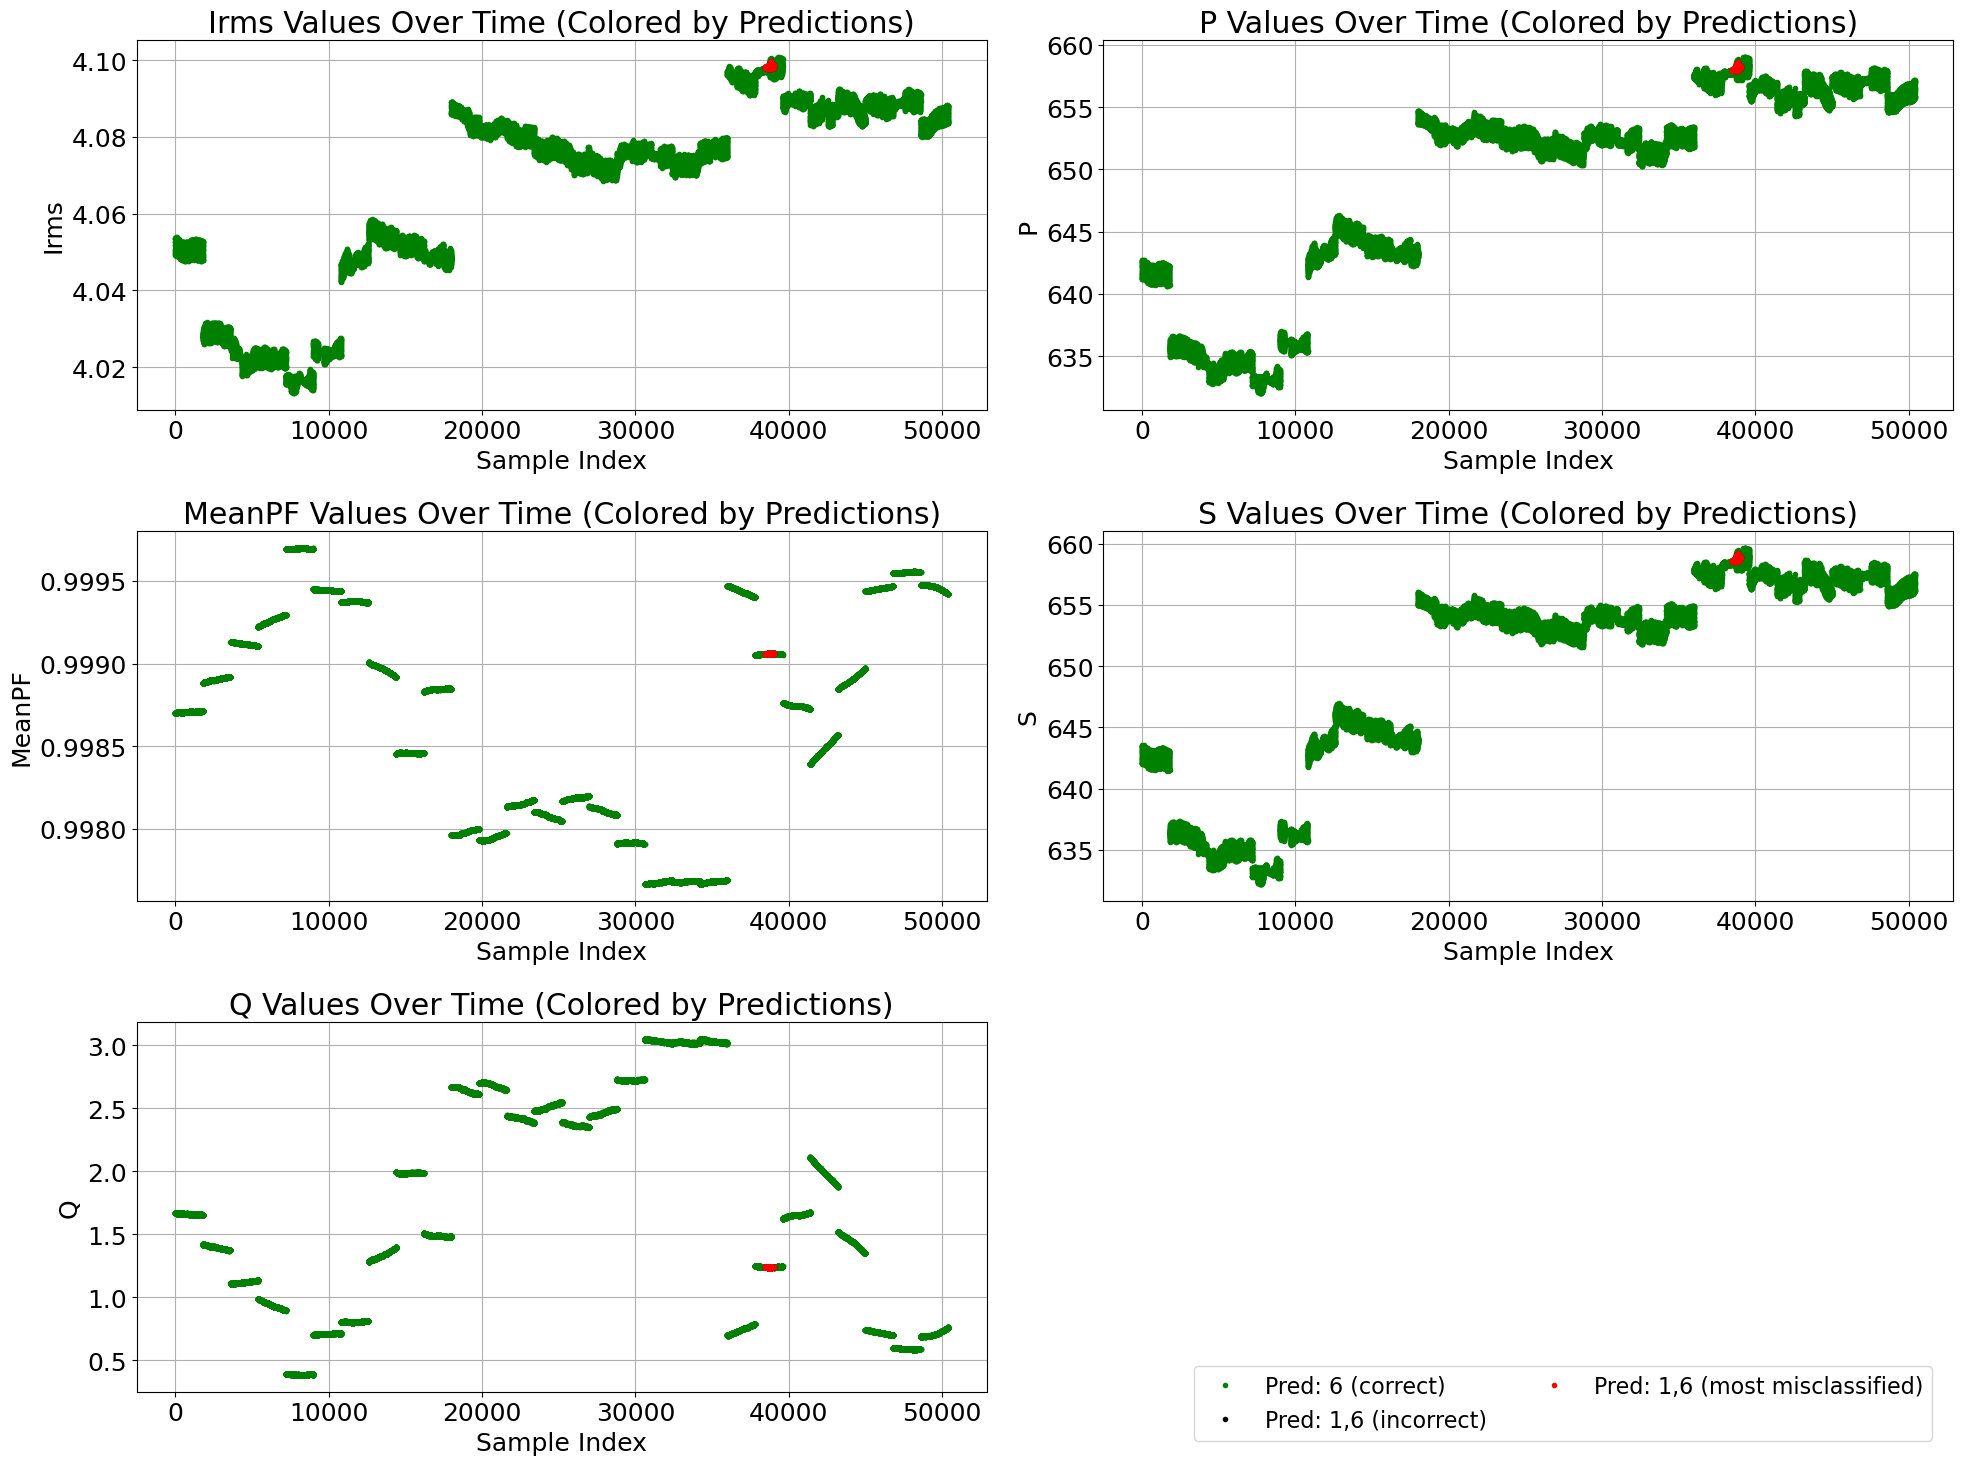

In [16]:
plot_features_distribution("6", val_df, scaler, features=["Irms", "P", "MeanPF", "S", "Q"], markersize=3)

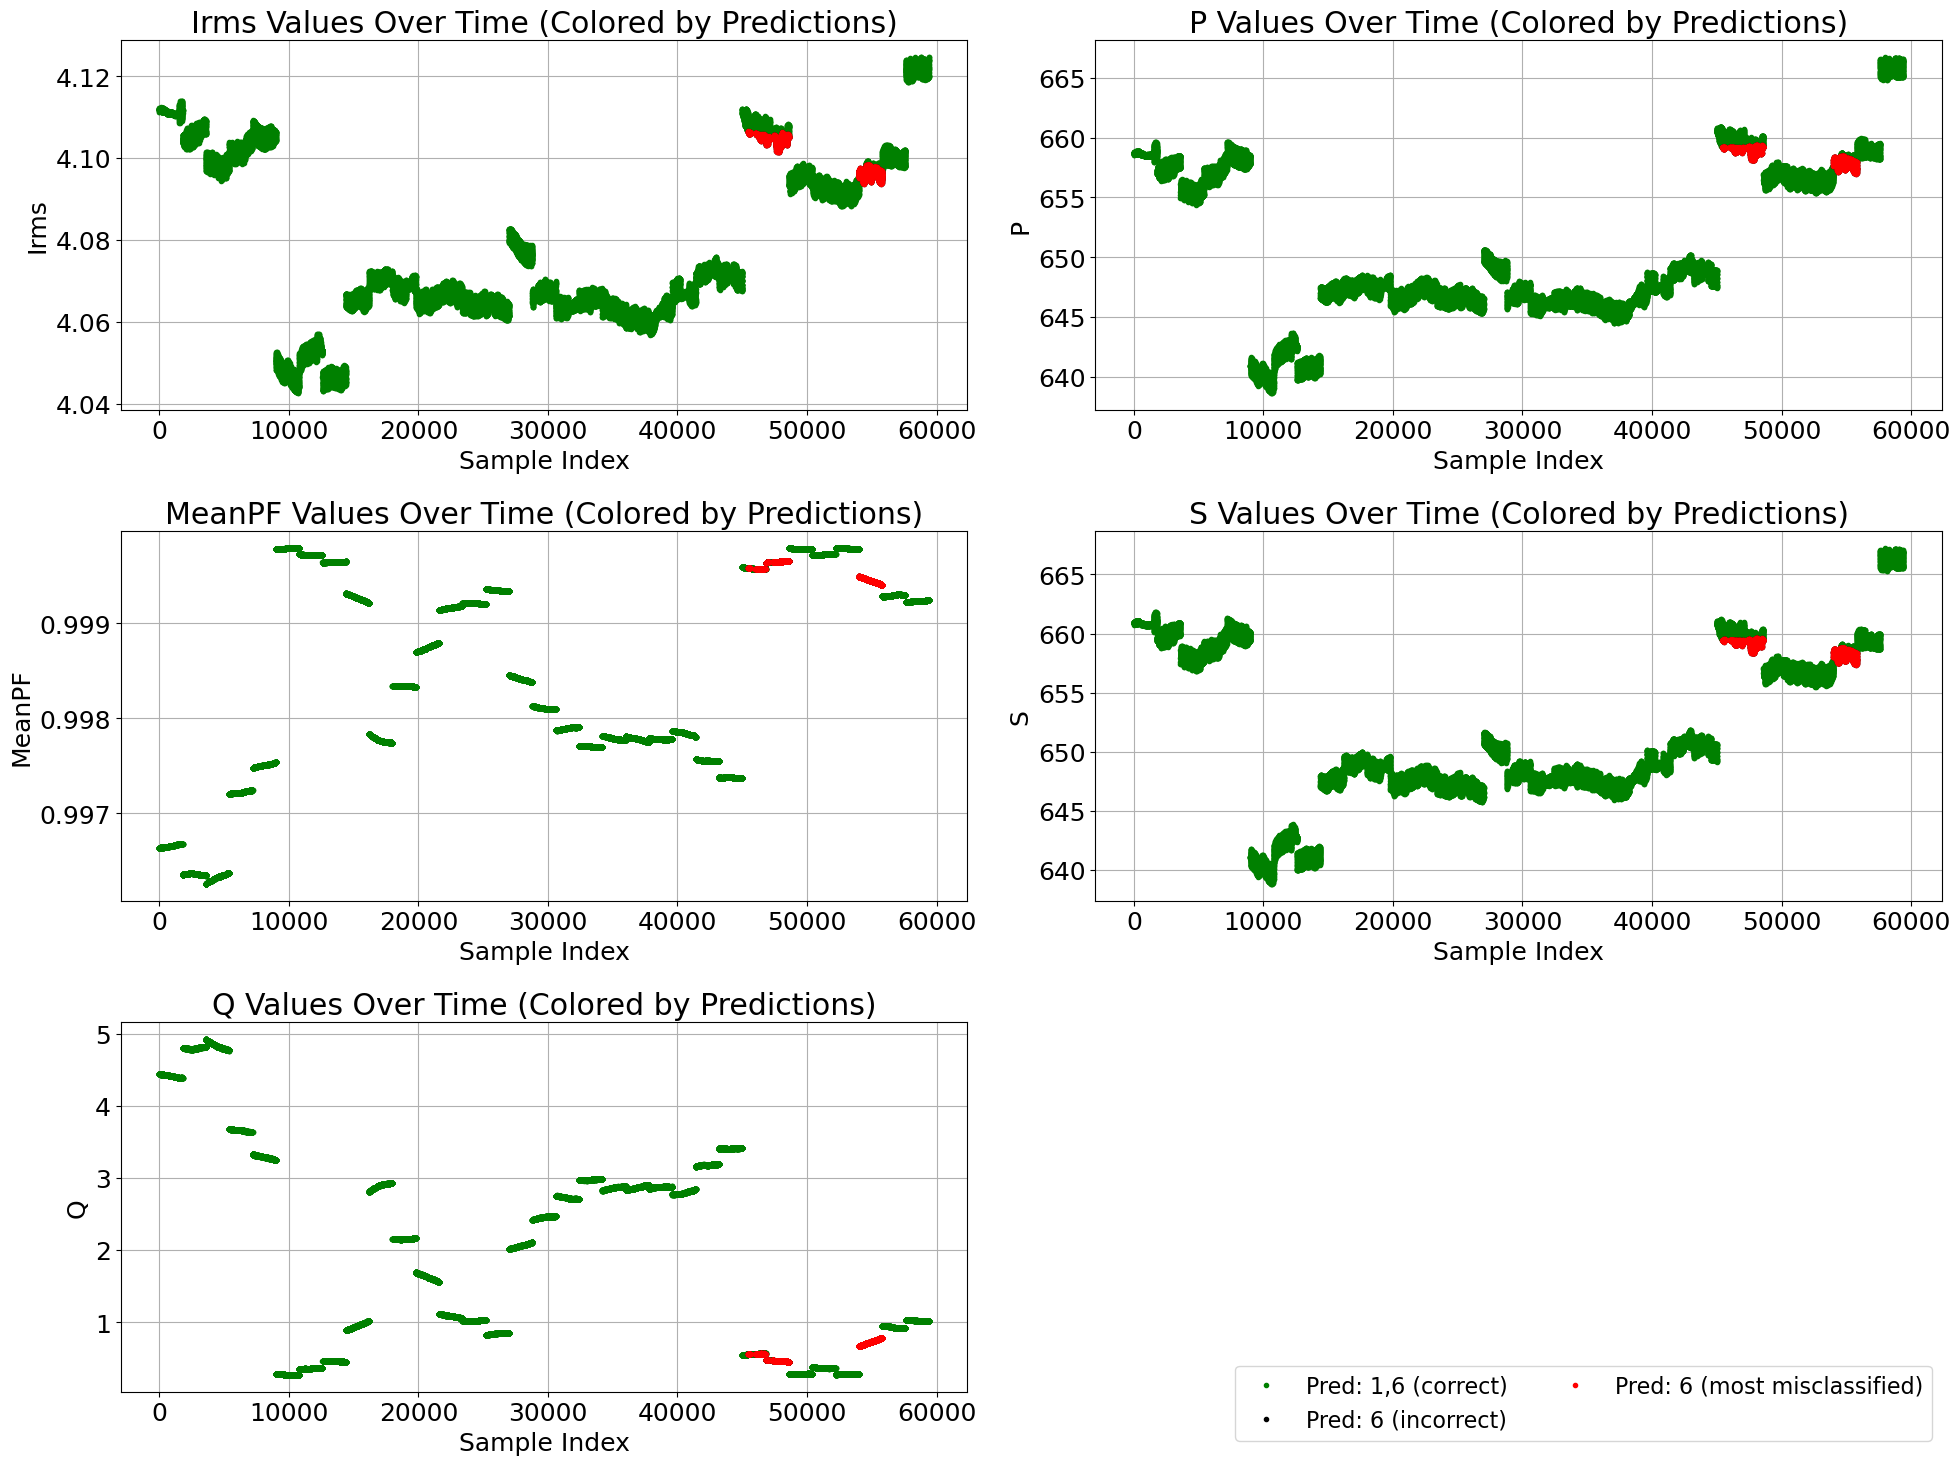

In [17]:
plot_features_distribution("1,6", val_df, scaler, features=["Irms", "P", "MeanPF", "S", "Q"], markersize=3)